# MNIST Model Comparison – Classical ML vs Deep Learning

In this notebook, we compare multiple models on the MNIST digit classification task:

- Logistic Regression
- K-Nearest Neighbors (KNN)
- Random Forest
- Multi-layer Perceptron (MLP – sklearn)
- Convolutional Neural Network (CNN – Keras)

We will train (some on subset for speed) and compare accuracy on the test set.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers, models

# for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()

print("Train:", x_train.shape, y_train.shape)
print("Test:", x_test.shape, y_test.shape)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 26s 2us/step
Train: (60000, 28, 28) (60000,)
Test: (10000, 28, 28) (10000,)


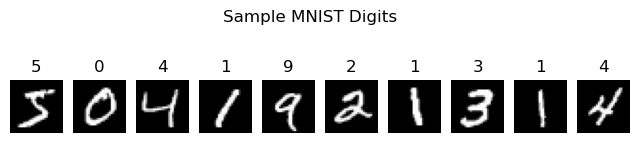

In [3]:
plt.figure(figsize=(8, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_train[i], cmap="gray")
    plt.axis("off")
    plt.title(y_train[i])
plt.suptitle("Sample MNIST Digits")
plt.show()


In [4]:
# Flatten 28x28 -> 784
X_train_flat = x_train.reshape((x_train.shape[0], -1)) / 255.0
X_test_flat  = x_test.reshape((x_test.shape[0], -1)) / 255.0

print("Flattened shape:", X_train_flat.shape)


Flattened shape: (60000, 784)


In [5]:
# use subset for classical ML (optional but faster)
subset = 20000   # 60k me se 20k
X_train_small = X_train_flat[:subset]
y_train_small = y_train[:subset]

print("Using subset:", X_train_small.shape)


Using subset: (20000, 784)


In [6]:
def evaluate_sklearn_model(name, model, X_tr, y_tr, X_te, y_te, results_dict):
    print(f"\n===== {name} =====")
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    print("Test Accuracy:", acc)
    results_dict[name] = acc
    return model


In [7]:
results = {}

# 1. Logistic Regression
log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
log_reg = evaluate_sklearn_model("Logistic Regression",
                                 log_reg,
                                 X_train_small, y_train_small,
                                 X_test_flat, y_test,
                                 results)

# 2. K-Nearest Neighbors
knn = KNeighborsClassifier(n_neighbors=5)
knn = evaluate_sklearn_model("KNN (k=5)",
                             knn,
                             X_train_small, y_train_small,
                             X_test_flat, y_test,
                             results)

# 3. Random Forest
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf = evaluate_sklearn_model("Random Forest",
                            rf,
                            X_train_small, y_train_small,
                            X_test_flat, y_test,
                            results)

# 4. MLP (sklearn)
mlp = MLPClassifier(hidden_layer_sizes=(256, 128),
                    activation='relu',
                    max_iter=20)
mlp = evaluate_sklearn_model("MLP (sklearn)",
                             mlp,
                             X_train_small, y_train_small,
                             X_test_flat, y_test,
                             results)

print("\nCurrent results:", results)



===== Logistic Regression =====
Test Accuracy: 0.9164

===== KNN (k=5) =====
Test Accuracy: 0.9549

===== Random Forest =====
Test Accuracy: 0.9567

===== MLP (sklearn) =====


C:\Anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Test Accuracy: 0.973

Current results: {'Logistic Regression': 0.9164, 'KNN (k=5)': 0.9549, 'Random Forest': 0.9567, 'MLP (sklearn)': 0.973}


In [8]:
# reshape to (N, 28, 28, 1)
X_train_cnn = x_train.astype("float32") / 255.0
X_test_cnn  = x_test.astype("float32") / 255.0

X_train_cnn = np.expand_dims(X_train_cnn, -1)
X_test_cnn  = np.expand_dims(X_test_cnn, -1)

num_classes = 10
y_train_cnn = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_cnn  = tf.keras.utils.to_categorical(y_test, num_classes)

print("CNN input shape:", X_train_cnn.shape)


CNN input shape: (60000, 28, 28, 1)


In [11]:
def build_cnn_model():
    model = models.Sequential([
        layers.Input(shape=(28, 28, 1)),        
        
        layers.Conv2D(32, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [12]:
cnn_model = build_cnn_model()
cnn_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    verbose=1
)


Epoch 1/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 37s 75ms/step - accuracy: 0.8997 - loss: 0.3282 - val_accuracy: 0.9823 - val_loss: 0.0597
Epoch 2/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 31s 74ms/step - accuracy: 0.9689 - loss: 0.1065 - val_accuracy: 0.9865 - val_loss: 0.0431
Epoch 3/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 78ms/step - accuracy: 0.9773 - loss: 0.0769 - val_accuracy: 0.9893 - val_loss: 0.0364
Epoch 4/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 33s 79ms/step - accuracy: 0.9810 - loss: 0.0642 - val_accuracy: 0.9892 - val_loss: 0.0360
Epoch 5/5
422/422 ━━━━━━━━━━━━━━━━━━━━ 38s 72ms/step - accuracy: 0.9836 - loss: 0.0544 - val_accuracy: 0.9902 - val_loss: 0.0346


In [15]:
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)
print("CNN Test Accuracy:", test_acc)

results["CNN (Keras)"] = test_acc


CNN Test Accuracy: 0.9904999732971191


In [17]:
import pandas as pd

results_df = pd.DataFrame(
    {"Model": list(results.keys()),
     "Test Accuracy": [round(v, 4) for v in results.values()]}
).sort_values(by="Test Accuracy", ascending=False)

results_df


,Model,Test Accuracy
4,CNN (Keras),0.9905
3,MLP (sklearn),0.9730
2,Random Forest,0.9567
1,KNN (k=5),0.9549
0,Logistic Regression,0.9164


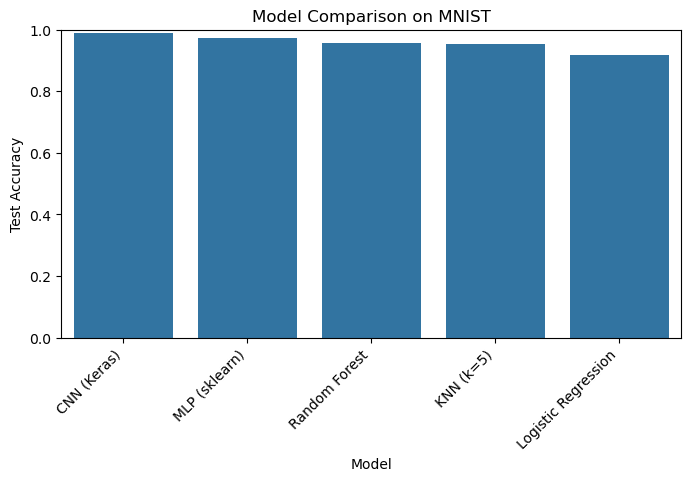

In [18]:
plt.figure(figsize=(8, 4))
sns.barplot(data=results_df, x="Model", y="Test Accuracy")
plt.xticks(rotation=45, ha="right")
plt.ylim(0, 1.0)
plt.title("Model Comparison on MNIST")
plt.show()


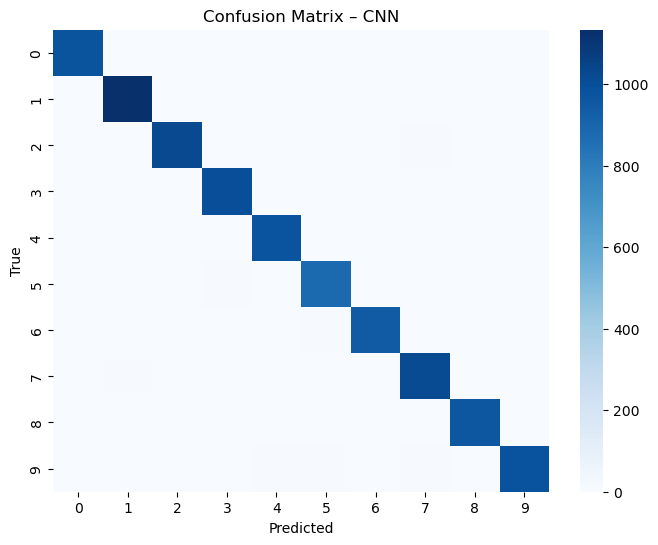

In [19]:
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn, verbose=0), axis=1)

cm = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix – CNN")
plt.show()


In [21]:
cnn_model.save("mnist_cnn.keras")
print("Model saved as mnist_cnn.keras")


Model saved as mnist_cnn.keras
